Random Forest 

In [54]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import math
boston = load_boston()

In [153]:
X=pd.DataFrame(boston.data)
y=pd.DataFrame(boston.target)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=616)

In [200]:
class Node():
    def __init__(self, feature_index=None, cutoff=None, left=None, right=None, variance=None, value=None):        
        
        self.feature_index = feature_index
        self.cutoff = cutoff
        self.left = left
        self.right = right
        self.variance = variance
        self.value = value

In [201]:
class Random_Forest():
    def __init__(self, min_samples_split=2, height=2):
        self.root = None
        
        self.min_samples_split = min_samples_split
        self.height = height
        
    def build_tree(self, dataset, curr_depth=0):        #this is a recursive function to build the tree
        
        X, Y = dataset[:,:-1], dataset[:,-1]  
        num_samples, num_features = np.shape(X)
        best_split = {}
        # spiltting
        if num_samples>=self.min_samples_split and curr_depth<=self.height:
            #  best split
            best_split = self.get_best_split(dataset, num_samples,num_features)
            # check if information gain is positive
            if best_split["variance"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["cutoff"], 
                            left_subtree, right_subtree, best_split["variance"])
        
        leaf_value = np.mean(Y)
        # returning leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples,num_features):
        
        best_split = {}
        max_variance = -float("inf")
        #sampling p/3 attributes
        n_rows,n_cols = dataset.shape 
        column = list(range(n_cols-1))
        num_features1 = random.sample(population=column,k=math.ceil(dataset.shape[1]/3))
    
        #looping over the features
        for feature_index in num_features1:
            ft_vals = dataset[:, feature_index]
            possible_cutoffs = np.unique(ft_vals)
            
            for cutoff in possible_cutoffs:
                # current split
                dataset_left, dataset_right = self.split(dataset, feature_index, cutoff)
                
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    curr_variance = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_variance>max_variance:
                        best_split["feature_index"] = feature_index
                        best_split["cutoff"] = cutoff
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["variance"] = curr_variance
                        max_variance = curr_variance
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, cutoff):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=cutoff])
        dataset_right = np.array([row for row in dataset if row[feature_index]>cutoff])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        prob_left = len(l_child) / len(parent)
        prob_right = len(r_child) / len(parent)
        reduction = np.var(parent) - (prob_left * np.var(l_child) + prob_right * np.var(r_child))
        return reduction
    
    
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.cutoff:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
                
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def fit(self, dataset):
        ''' function to train the tree '''
          
        self.root = self.build_tree(dataset.values)

In [160]:
train_MSE = np.zeros(6)
test_MSE = np.zeros(6)

In [203]:
#bootstarpping X  
F = Random_Forest(min_samples_split=3,height=2)
def random_forest(X,y,n_trees,height):
    forest = []   
    for i in range(n_trees):
        b_indices = np.random.randint(low=0, high=len(X), size=len(X))
        y1=y.rename(columns={0:"13"})
        Train_df = pd.concat([X,y1],axis=1)
        BTS =  Train_df.iloc[b_indices]  
        tree = F.fit(BTS)
        forest.append(tree)
    return forest

In [158]:
#calculating MSE using different values of B and h
B = [10,40,20,80,100,100]
H = [2,3,4,3,2,3]

In [165]:
random_forest(X_train,y_train,B[0],H[0])
Y_pred00 = F.predict(X_train.values) 
train_MSE[0] = np.sqrt(mean_squared_error(y_train.values, Y_pred00))
random_forest(X_test,y_test,B[0],H[0])
Y_pred01 = F.predict(X_test.values) 
test_MSE[0] = np.sqrt(mean_squared_error(y_test.values, Y_pred01))

In [177]:
random_forest(X_train,y_train,B[1],H[1])
Y_pred10 = F.predict(X_train.values) 
train_MSE[1] = np.sqrt(mean_squared_error(y_train.values, Y_pred10))
random_forest(X_test,y_test,B[1],H[1])
Y_pred11 = F.predict(X_test.values) 
test_MSE[1] = np.sqrt(mean_squared_error(y_test.values, Y_pred11))

In [171]:
random_forest(X_train,y_train,B[2],H[2])
Y_pred20 = F.predict(X_train.values) 
train_MSE[2] = np.sqrt(mean_squared_error(y_train.values, Y_pred20))
random_forest(X_test,y_test,B[2],H[2])
Y_pred21 = F.predict(X_test.values) 
test_MSE[2] = np.sqrt(mean_squared_error(y_test.values, Y_pred21))

In [172]:
random_forest(X_train,y_train,B[3],H[3])
Y_pred30 = F.predict(X_train.values) 
train_MSE[3] = np.sqrt(mean_squared_error(y_train.values, Y_pred30))
random_forest(X_test,y_test,B[3],H[3])
Y_pred31 = F.predict(X_test.values) 
test_MSE[3] = np.sqrt(mean_squared_error(y_test.values, Y_pred31))

In [206]:
random_forest(X_train,y_train,B[4],H[4])
Y_pred40 = F.predict(X_train.values) 
train_MSE[4] = np.sqrt(mean_squared_error(y_train.values, Y_pred40))
random_forest(X_test,y_test,B[4],H[4])
Y_pred41 = F.predict(X_test.values) 
test_MSE[4] = np.sqrt(mean_squared_error(y_test.values, Y_pred41))

In [179]:
random_forest(X_train,y_train,B[5],H[5])
Y_pred50 = F.predict(X_train.values) 
train_MSE[5] = np.sqrt(mean_squared_error(y_train.values, Y_pred50))
random_forest(X_test,y_test,B[5],H[5])
Y_pred51 = F.predict(X_test.values) 
test_MSE[5] = np.sqrt(mean_squared_error(y_test.values, Y_pred51))

In [207]:
print(train_MSE)
print(test_MSE)

[4.79519807 5.39074578 5.69500904 5.88227378 6.12626889 4.76095867]
[4.89239936 3.93745738 4.70356315 3.65945286 3.56552563 4.65799155]


Text(0, 0.5, 'MSE')

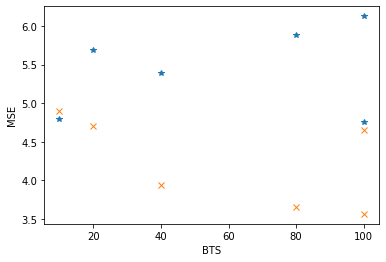

In [208]:
plt.plot(B,train_MSE,'*')
plt.plot(B,test_MSE,'x')
plt.xlabel("BTS")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

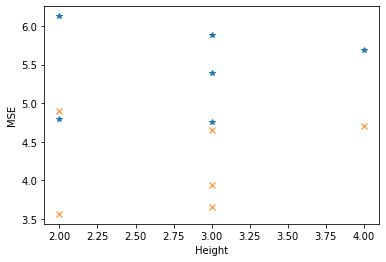

In [209]:
plt.plot(H,train_MSE,'*')
plt.plot(H,test_MSE,'x')
plt.xlabel("Height")
plt.ylabel("MSE")